# Solver Run Time Comparison
***
## Setup the Environment
***

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../../GillesPy2/')))

MatPlotLib is used for creating custom visualizations

In [2]:
import matplotlib.pyplot as plt

In [3]:
import time

In [4]:
import gillespy2

***
## Create the Simple Hybrid Model
***

In [5]:
def create_birth_death_model( initial_value=1 ):
    # Initialize Model
    model = gillespy2.Model(name="Birth-Death")

    # Define Variables (GillesPy2.Species)
    A = gillespy2.Species(name='A', initial_value = initial_value )
    V = gillespy2.Species(name='V', initial_value = initial_value ) # used as a constant scaling factor

    # Add Variables to Model
    model.add_species([A, V])

    # Define Parameters
    rate1 = gillespy2.Parameter(name='rate1', expression= 10.0)
    rate2 = gillespy2.Parameter(name='rate2', expression= 10.0)
    
    # Add Parameters to Model
    model.add_parameter([rate1, rate2])

    # Define Reactions
    r1 = gillespy2.Reaction(name="r1", reactants={}, products={'A': 1}, propensity_function="rate1 * V")
    r2 = gillespy2.Reaction(name="r2", reactants={'A': 1}, products={}, rate='rate2')

    # Add Reactions to Model
    model.add_reaction([r1, r2])
    
    # Define Timespan
    tspan = gillespy2.TimeSpan.linspace(t=100, num_points=101)
    
    # Set Model Timespan
    model.timespan(tspan)
    return model

***
## Run the Simulations
***
### Time Comparison Test Method

In [6]:
all_solvers = {}
for s in dir(gillespy2.solvers):
    if s.endswith('Solver'):
        #print(s)
        all_solvers[s]=eval('gillespy2.solvers.'+s)
all_solvers

{'CLESolver': gillespy2.solvers.numpy.CLE_solver.CLESolver,
 'NumPySSASolver': gillespy2.solvers.numpy.ssa_solver.NumPySSASolver,
 'ODECSolver': gillespy2.solvers.cpp.ode_c_solver.ODECSolver,
 'ODESolver': gillespy2.solvers.numpy.ode_solver.ODESolver,
 'SSACSolver': gillespy2.solvers.cpp.ssa_c_solver.SSACSolver,
 'TauHybridCSolver': gillespy2.solvers.cpp.tau_hybrid_c_solver.TauHybridCSolver,
 'TauHybridSolver': gillespy2.solvers.numpy.tau_hybrid_solver.TauHybridSolver,
 'TauLeapingCSolver': gillespy2.solvers.cpp.tau_leaping_c_solver.TauLeapingCSolver,
 'TauLeapingSolver': gillespy2.solvers.numpy.tau_leaping_solver.TauLeapingSolver,
 'VariableSSACSolver': gillespy2.solvers.cpp.variable_ssa_c_solver.VariableSSACSolver}

In [7]:
Solver_plot_order = ['SSA','TauHybrid','TauLeaping','ODE']

In [8]:
C_solvers = {
 'ODE': gillespy2.solvers.cpp.ode_c_solver.ODECSolver,
 'SSA': gillespy2.solvers.cpp.ssa_c_solver.SSACSolver,
 'TauHybrid': gillespy2.solvers.cpp.tau_hybrid_c_solver.TauHybridCSolver,
 'TauLeaping': gillespy2.solvers.cpp.tau_leaping_c_solver.TauLeapingCSolver}

In [9]:
NumPy_solvers = {
 'SSA': gillespy2.solvers.numpy.ssa_solver.NumPySSASolver,
 'ODE': gillespy2.solvers.numpy.ode_solver.ODESolver,
 'TauHybrid': gillespy2.solvers.numpy.tau_hybrid_solver.TauHybridSolver,
 'TauLeaping': gillespy2.solvers.numpy.tau_leaping_solver.TauLeapingSolver
}

In [10]:
def run_test(solverClass, max_time=0.5):
    import inspect
    if 'variable' in inspect.signature(solverClass).parameters.keys():
        model = create_birth_death_model()
        solver = solverClass(model=model, variable=True)
        run_times = []
        for val in v_range:
            time_start = time.perf_counter()
            model.run(solver=solver, variables={"V": val,"A": val})
            time_end = time.perf_counter()
            run_times.append(time_end - time_start)
            if (time_end - time_start) > max_time:
                break
        return run_times
    else:
        run_times = []
        for val in v_range:
            model = create_birth_death_model(val)
            solver = solverClass(model=model)
            time_start = time.perf_counter()
            model.run(solver=solver)
            time_end = time.perf_counter()
            run_times.append(time_end - time_start)
            if (time_end - time_start) > max_time:
                break
        return run_times
        

In [11]:
def run_all_test(solver_list, max_time=0.5):
    timing_data = {}
    for name,solver in solver_list.items():
        print(name, end=' ')
        try:
            time_start = time.perf_counter()
            timing_data[name] = run_test(solver, max_time=max_time)
            time_end = time.perf_counter()
            print(len(timing_data[name]), end=' ')
            print(str(time_end - time_start)+'s')
        except Exception as e:
            print("Caught: "+str(e))
    return timing_data

# C++ Solvers

In [12]:
v_range = range(1, 3000, 20)

In [13]:
%time C_solver_timing_data = run_all_test(C_solvers)

ODE 150 7.302137960999971s
SSA 150 22.987358434009366s
TauHybrid 150 31.9342300669814s
TauLeaping 150 11.27814969298197s
CPU times: user 830 ms, sys: 1.42 s, total: 2.25 s
Wall time: 1min 13s


In [14]:
C_solver_timing_data

{'ODE': [0.006837028980953619,
  0.0059601069951895624,
  0.005425429990282282,
  0.004980678990250453,
  0.005214994976995513,
  0.0051996519905515015,
  0.005303107987856492,
  0.005465497000841424,
  0.00538065898581408,
  0.00531588401645422,
  0.005394365987740457,
  0.005301680997945368,
  0.005381561000831425,
  0.005332686996553093,
  0.005042074975790456,
  0.005175336002139375,
  0.005466293019708246,
  0.005320875003235415,
  0.005033349996665493,
  0.00516358099412173,
  0.0057460489915683866,
  0.005214323988184333,
  0.005172548990231007,
  0.005268451990559697,
  0.0052647079864982516,
  0.0051296279998496175,
  0.0051808980060741305,
  0.005113070015795529,
  0.005096520995721221,
  0.005185844987863675,
  0.00525794699206017,
  0.005626569996820763,
  0.0054247820226009935,
  0.005311095010256395,
  0.005338532995665446,
  0.005274859984638169,
  0.004998137999791652,
  0.005015016999095678,
  0.005074501998024061,
  0.005335485009709373,
  0.005205772002227604,
  0.00

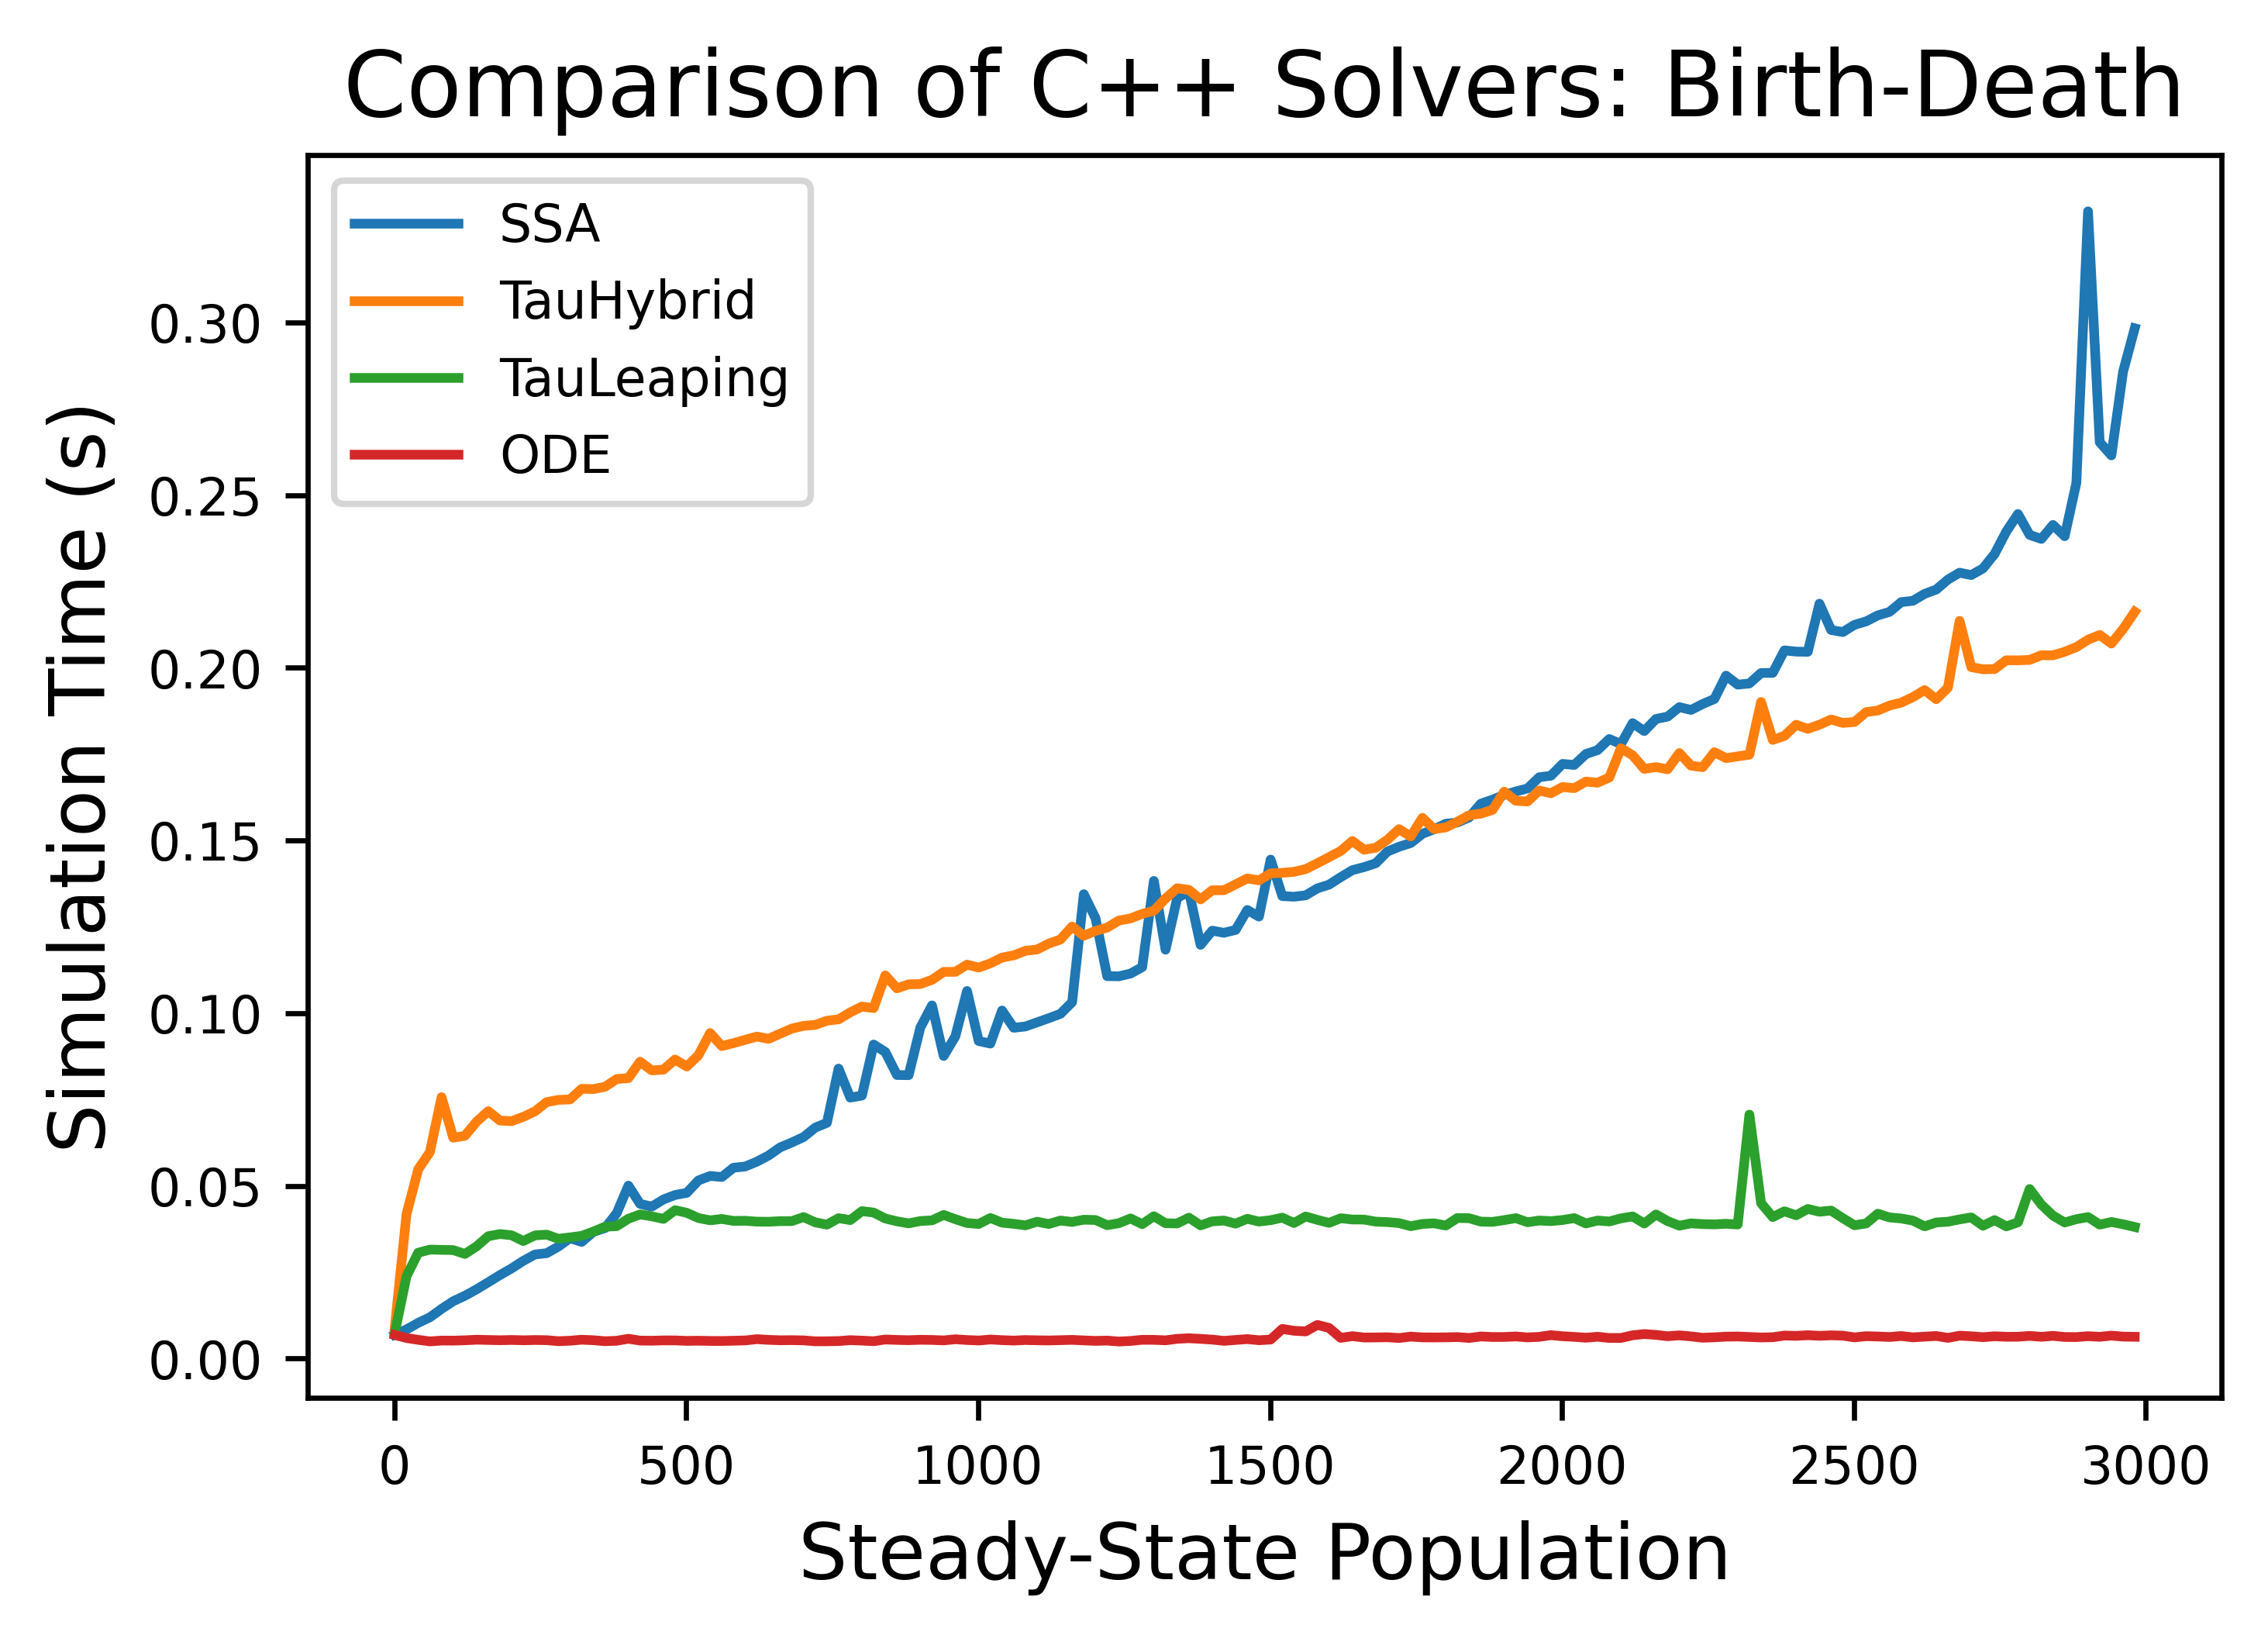

In [15]:
#fig = plt.figure(figsize=(3.54,3.54), dpi=600)
fig = plt.figure(figsize=(5.31,3.54), dpi=600)
#for name,times in C_solver_timing_data.items():
for name in Solver_plot_order:
    times = C_solver_timing_data[name]
    name2=name.replace('CSolver','')
    try:
        plt.plot(v_range[0:len(C_solver_timing_data[name])], C_solver_timing_data[name], label=name2)
    except Exception as e:
        print(name)
        raise e
plt.title("Comparison of C++ Solvers: Birth-Death", fontsize=14)
plt.xlabel('Steady-State Population', fontsize=12)
plt.ylabel('Simulation Time (s)', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(loc='best', fontsize=8)
plt.savefig('../images/Time_Comparison_Of_Solvers.pdf', bbox_inches='tight')

# Numpy Solvers

In [16]:
v_range = range(1, 50, 1)

In [17]:
%time NumPy_solvers_timing_data = run_all_test(NumPy_solvers, max_time=4)

SSA 49 24.863662061979994s
ODE 49 0.09659490900230594s
TauHybrid 13 30.198319546994753s
TauLeaping 49 16.23560015199473s
CPU times: user 1min 11s, sys: 165 ms, total: 1min 11s
Wall time: 1min 11s


In [18]:
NumPy_solvers_timing_data.items()

dict_items([('SSA', [0.02922917000250891, 0.04618730102083646, 0.0593894729972817, 0.08062160399276763, 0.10282098699826747, 0.11710514899459668, 0.15015804499853402, 0.1626179279992357, 0.17650957399746403, 0.20448457400198095, 0.21340685500763357, 0.23828182599390857, 0.25136688799830154, 0.273682536004344, 0.2982341749884654, 0.31326778398943134, 0.3285982539819088, 0.35745952400611714, 0.36351118399761617, 0.3914970589976292, 0.42646458599483594, 0.4282196690037381, 0.45525300898589194, 0.47835334797855467, 0.49223361600888893, 0.5212932540162001, 0.5348319040203933, 0.559592089994112, 0.574938136007404, 0.6122184869891498, 0.6126059470116161, 0.639108931994997, 0.6538682479877025, 0.6866376349935308, 0.693078112002695, 0.7185711379861459, 0.7500529559911229, 0.742953528999351, 0.774564172985265, 1.1007735610182863, 0.9420225920039229, 0.8413221990049351, 0.8558975929918233, 0.8719618059985805, 0.8955058940046001, 0.9147101160197053, 0.9643816769821569, 0.9555714320158586, 0.968879

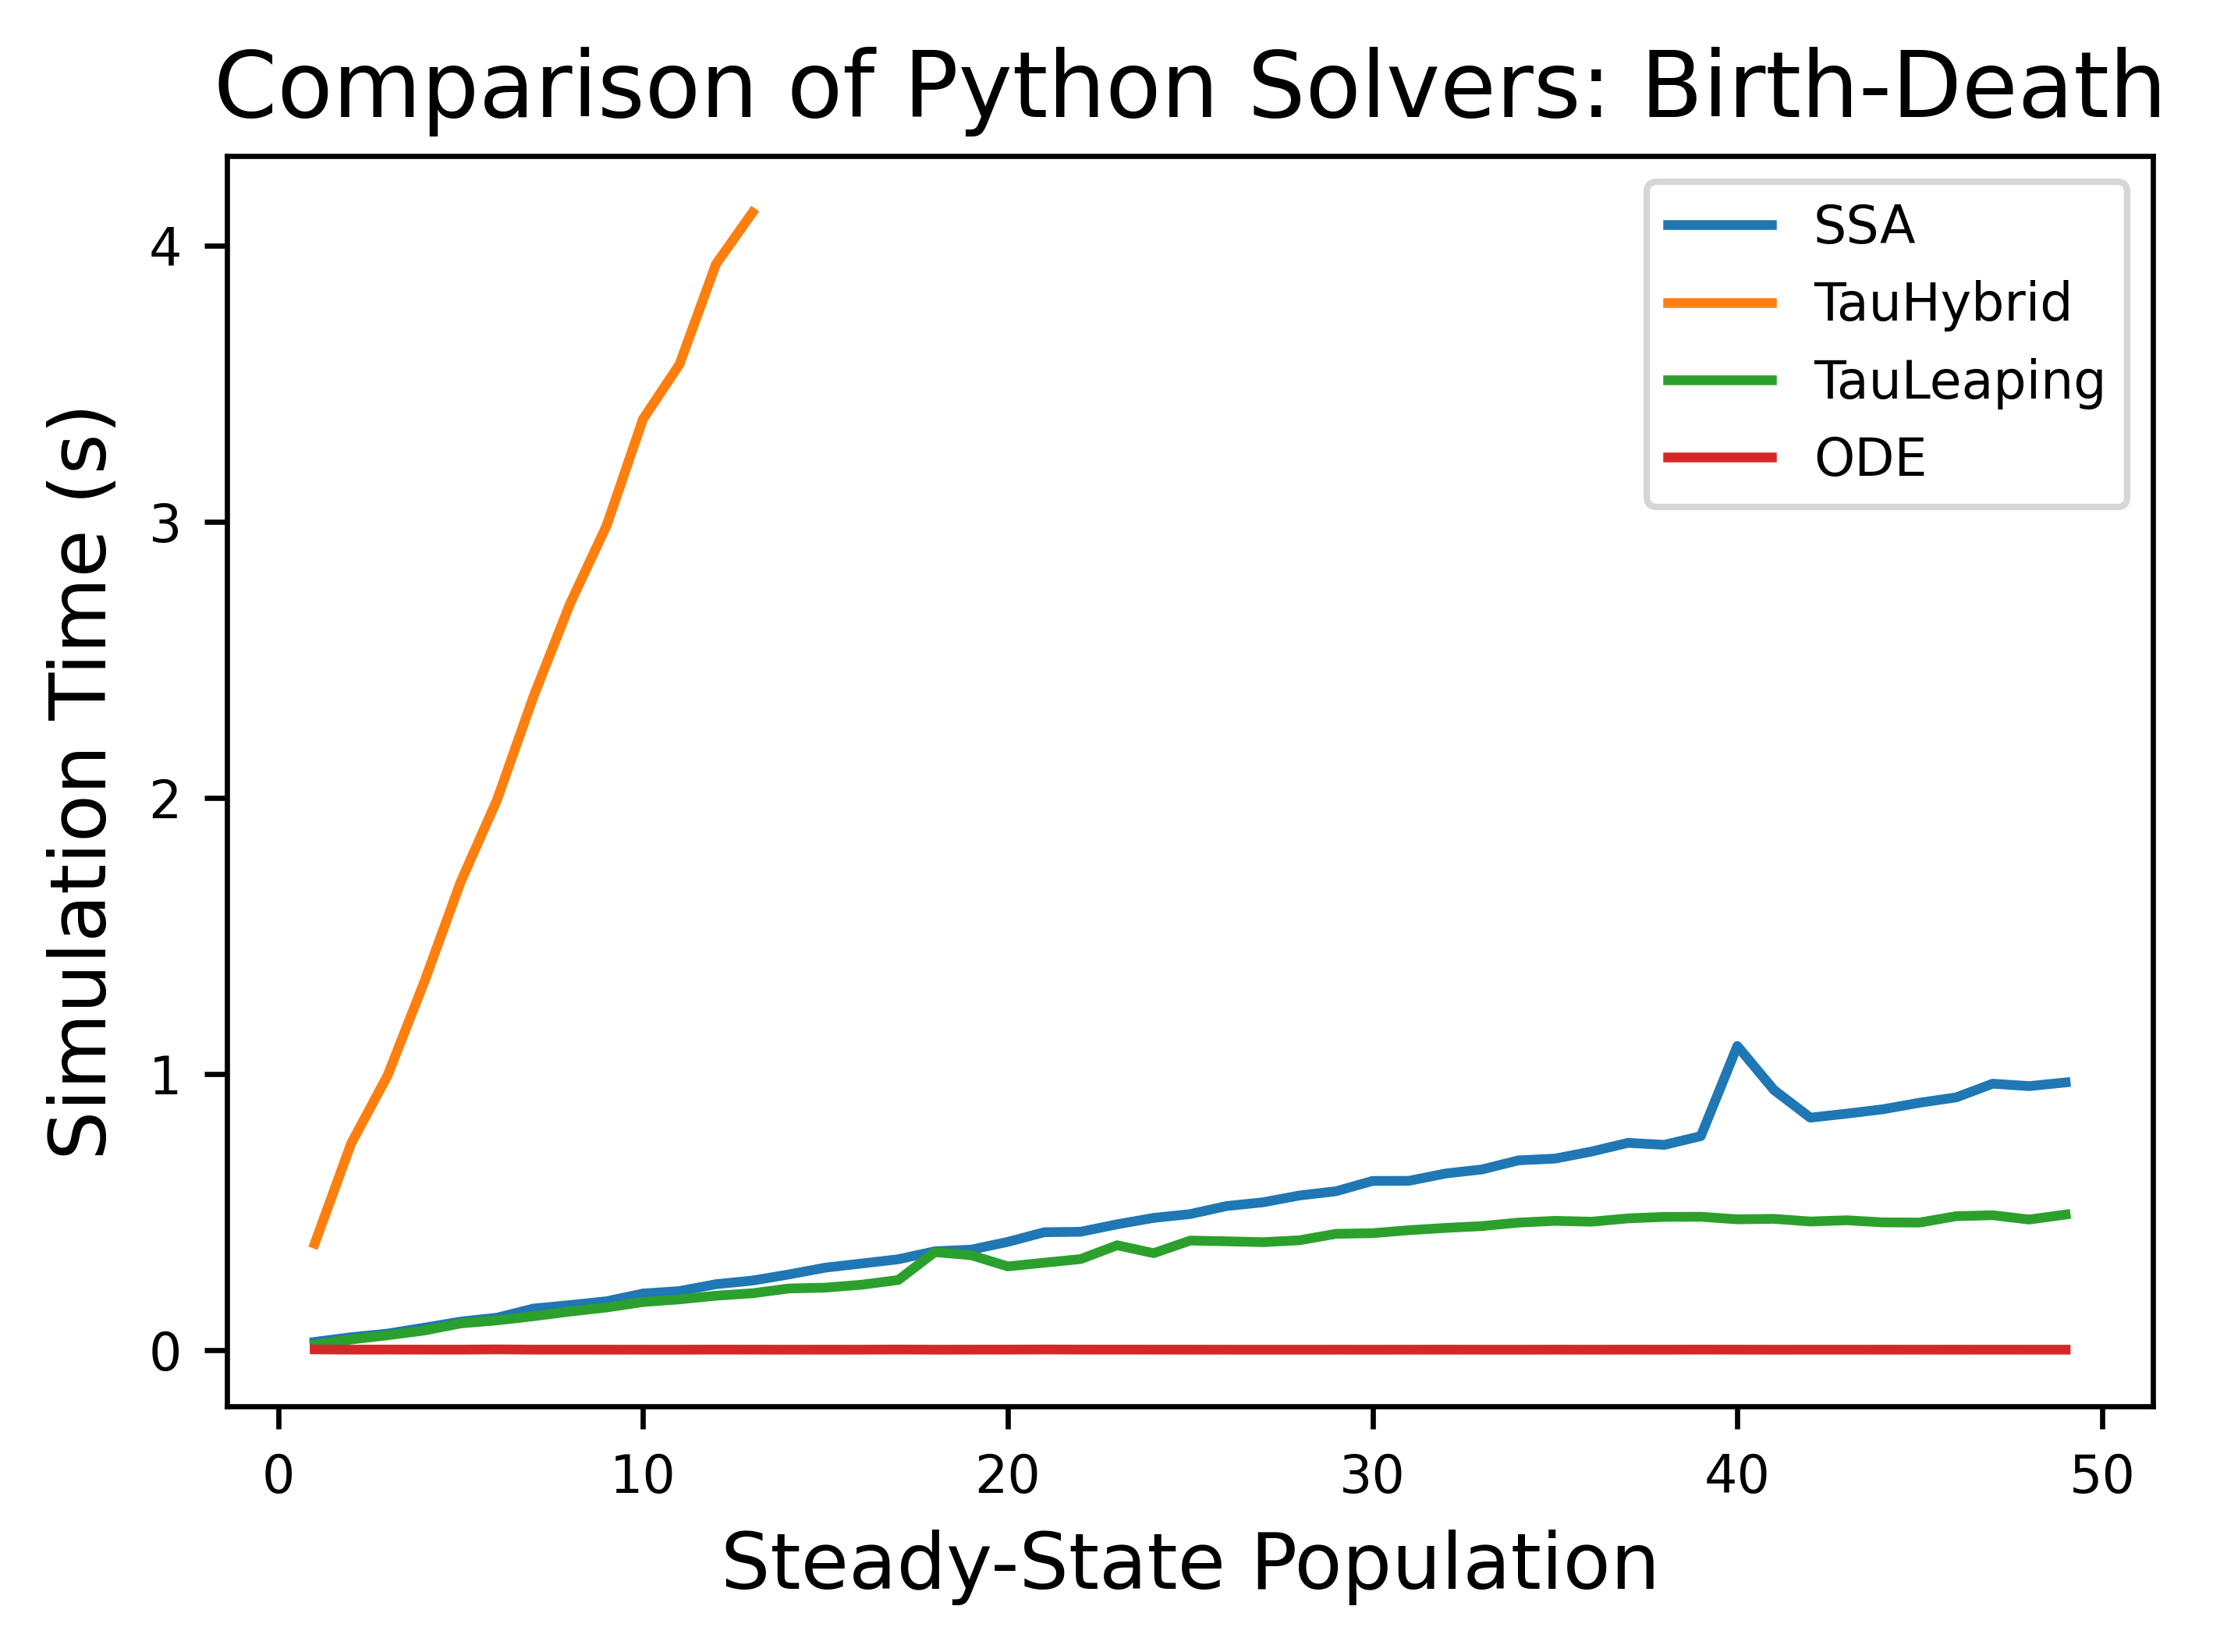

In [19]:
fig = plt.figure(figsize=(5.31,3.54), dpi=600)
for name in Solver_plot_order:
    times = C_solver_timing_data[name]
    name2=name.replace('CSolver','')
    plt.plot(v_range[0:len(NumPy_solvers_timing_data[name])], NumPy_solvers_timing_data[name], label=name2)
plt.title("Comparison of Python Solvers: Birth-Death", fontsize=14)
plt.xlabel('Steady-State Population', fontsize=12)
plt.ylabel('Simulation Time (s)', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(loc='best', fontsize=8)
plt.savefig('../images/Time_Comparison_Of_Python_Solvers.pdf', bbox_inches='tight')

In [20]:
raise Exception('stop')

Exception: stop

### SSA

In [ ]:
%time timing_data['SSA'] = run_test("SSA")

### Tau Leaping

In [ ]:
%time timing_data['tau_leaping'] = run_test("Tau-Leaping")

### Tau Hybrid

In [ ]:
%time timing_data['hybrid_tau'] = run_test("Tau-Hybrid")

***
## Visualizations
***

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Time Comparison of Solvers")
plt.xlabel("initial Value of V (species count)")
plt.ylabel("Simulation Run Time (s)")
plt.plot(v_range, timing_data['SSA'], label='SSA')
plt.plot(v_range, timing_data['tau_leaping'], label='tau_leaping')
plt.plot(v_range, timing_data['hybrid_tau'], label='hybrid_tau')
plt.legend(loc='best')
#plt.savefig("Time_Comparison_Of_Solvers.pdf")